# Imports

In [1]:
import os
import sys
import pickle
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))

from SRModels.constants import *
from SRModels.loading_methods import load_predictions_dataset
from SRModels.deep_learning_models.SRCNN_model import SRCNNModel
from SRModels.deep_learning_models.EDSR_model import EDSR
from SRModels.deep_learning_models.ESRGAN_model import ESRGAN
from SRModels.defect_detection_models.VGG16_model import FineTunedVGG16
from SRModels.deep_lerning_visualizations import *
from SRModels.classic_super_resolution_algorithms.classic_algorithms import *

c:\Users\bgmanuel\anaconda3\envs\py310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\bgmanuel\anaconda3\envs\py310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.

# CONSTANTS

In [2]:
SRCNN_PRETRAINED_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/SRCNN/SRCNN_20250909_205417/SRCNN_20250909_205417.h5"))
SRCNN_HR_DIMENSIONS_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/SRCNN/SRCNN_20250909_205417/SRCNN_20250909_205417_hrh_hrw.pkl"))
SRCNN_TRAIN_METRICS_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/SRCNN/SRCNN_20250909_205417/SRCNN_20250909_205417_metrics.pkl"))

EDSR_PRETRAINED_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/EDSR/EDSR_20250909_205911/EDSR_x2_20250909_205911.h5"))
EDSR_TRAIN_METRICS_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/EDSR/EDSR_20250909_205911/EDSR_20250909_205911_metrics.pkl"))

ESRGAN_GENERATOR_PRETRAINED_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/ESRGAN/ESRGAN_20250909_193854/ESRGAN_generator_x2_20250909_193854.h5"))
ESRGAN_DISCRIMINATOR_PRETRAINED_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/ESRGAN/ESRGAN_20250909_193854/ESRGAN_discriminator_x2_20250909_193854.h5"))
ESRGAN_TRAIN_METRICS_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/ESRGAN/ESRGAN_20250909_193854/ESRGAN_20250909_193854_metrics.pkl"))

VGG16_PRETRAINED_PATH = os.path.abspath(os.path.join(os.getcwd(), "defect_detection_models/models/VGG16/VGG16_20250909_204806/VGG16_20250909_204806.h5"))
VGG16_TRAIN_METRICS_PATH = os.path.abspath(os.path.join(os.getcwd(), "defect_detection_models/models/VGG16/VGG16_20250909_204806/VGG16_20250909_204806_metrics.pkl"))

# LR Dataset loading

In [3]:
# Paths to LR images and labels map generated by preprocessing_functions
HR_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../data/images_for_predictions/HR"))
LR_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../data/images_for_predictions/LR"))
CLASS_LABELS_PATH = os.path.abspath(os.path.join(os.getcwd(), "../data/images_for_predictions/predictions_class_labels_map.pkl"))

# Load arrays (aligned LR/HR pairs)
X_LR, X_HR, y = load_predictions_dataset(LR_ROOT, HR_ROOT, CLASS_LABELS_PATH)
print(f"Loaded LR images: {X_LR.shape} | HR images: {X_HR.shape} | Labels: {y.shape}")

Loaded LR images: (113, 239, 239, 3) | HR images: (113, 478, 478, 3) | Labels: (113,)


In [4]:
# Load HR dimensions
with open(SRCNN_HR_DIMENSIONS_PATH, "rb") as f:
    hr_h, hr_w = pickle.load(f)

# Interpolacion bilineal superresolution

In [5]:
bilinear_sr_images = []
for lr_img in X_LR:
    sr = interpolate_bilinear(lr_img, target_shape=(hr_w, hr_h))
    bilinear_sr_images.append(sr)

# Interpolacion bicubica superresolution

In [6]:
bicubic_sr_images = []
for lr_img in X_LR:
    sr = interpolate_bicubic(lr_img, target_shape=(hr_w, hr_h))
    bicubic_sr_images.append(sr)

# Interpolacion por area superresolution

In [7]:
area_sr_images = []
for lr_img in X_LR:
    sr = interpolate_area(lr_img, target_shape=(hr_w, hr_h))
    area_sr_images.append(sr)

# Interpolacion Lanczos superresolution

In [8]:
lanczos_sr_images = []
for lr_img in X_LR:
    sr = interpolate_lanczos(lr_img, target_shape=(hr_w, hr_h))
    lanczos_sr_images.append(sr)

# Iterative Back-Projection superresolution

In [9]:
backproj_sr_images = []
for idx, lr_img in enumerate(X_LR):
    # Convert LR to grayscale from RGB float [0,1] -> uint8
    if lr_img.ndim == 3 and lr_img.shape[2] == 3:
        lr_g = cv2.cvtColor((lr_img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    else:
        lr_g = (lr_img * 255).astype(np.uint8) if lr_img.dtype != np.uint8 else lr_img

    # Use corresponding HR image as initial HR reference (grayscale uint8)
    hr_img = X_HR[idx]
    if hr_img.ndim == 3 and hr_img.shape[2] == 3:
        hr_g = cv2.cvtColor((hr_img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    else:
        hr_g = (hr_img * 255).astype(np.uint8) if hr_img.dtype != np.uint8 else hr_img

    sr_g = back_projection(hr_g, lr_g, iterations=10)
    # Convert back to 3 channels for consistency
    backproj_sr_images.append(cv2.cvtColor(sr_g, cv2.COLOR_GRAY2BGR))

# Non-Local Means denoise + upscale superresolution

In [10]:
nlm_sr_images = []
for idx, lr_img in enumerate(X_LR):
    # LR grayscale
    if lr_img.ndim == 3 and lr_img.shape[2] == 3:
        lr_g = cv2.cvtColor((lr_img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    else:
        lr_g = (lr_img * 255).astype(np.uint8) if lr_img.dtype != np.uint8 else lr_img
    # HR grayscale reference
    hr_img = X_HR[idx]
    if hr_img.ndim == 3 and hr_img.shape[2] == 3:
        hr_g = cv2.cvtColor((hr_img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    else:
        hr_g = (hr_img * 255).astype(np.uint8) if hr_img.dtype != np.uint8 else hr_img

    sr_g = non_local_means(hr_g, lr_g)
    # Convert to uint8 if needed and expand to 3 channels
    sr_u8 = (sr_g * 255).astype(np.uint8) if sr_g.dtype != np.uint8 else sr_g
    nlm_sr_images.append(cv2.cvtColor(sr_u8, cv2.COLOR_GRAY2BGR))

# Edge-guided interpolation superresolution

In [11]:
edge_guided_sr_images = []
for idx, lr_img in enumerate(X_LR):
    # LR grayscale
    if lr_img.ndim == 3 and lr_img.shape[2] == 3:
        lr_g = cv2.cvtColor((lr_img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    else:
        lr_g = (lr_img * 255).astype(np.uint8) if lr_img.dtype != np.uint8 else lr_img
    # HR grayscale reference
    hr_img = X_HR[idx]
    if hr_img.ndim == 3 and hr_img.shape[2] == 3:
        ref_hr_g = cv2.cvtColor((hr_img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    else:
        ref_hr_g = (hr_img * 255).astype(np.uint8) if hr_img.dtype != np.uint8 else hr_img

    sr_g = edge_guided_interpolation(ref_hr_g, lr_g)
    edge_guided_sr_images.append(cv2.cvtColor(sr_g, cv2.COLOR_GRAY2BGR))

# Frequency-domain extrapolation superresolution

In [12]:
freq_extrap_sr_images = []
for idx, lr_img in enumerate(X_LR):
    if lr_img.ndim == 3 and lr_img.shape[2] == 3:
        lr_g = cv2.cvtColor((lr_img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    else:
        lr_g = (lr_img * 255).astype(np.uint8) if lr_img.dtype != np.uint8 else lr_img
    # HR grayscale reference
    hr_img = X_HR[idx]
    if hr_img.ndim == 3 and hr_img.shape[2] == 3:
        ref_hr_g = cv2.cvtColor((hr_img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    else:
        ref_hr_g = (hr_img * 255).astype(np.uint8) if hr_img.dtype != np.uint8 else hr_img

    sr_g = frequency_extrapolation(ref_hr_g, lr_g)
    # frequency_extrapolation returns float magnitude; normalize to uint8
    sr_g_norm = sr_g
    if sr_g_norm.dtype != np.uint8:
        sr_g_norm = sr_g_norm - sr_g_norm.min()
        maxv = sr_g_norm.max() if sr_g_norm.max() != 0 else 1.0
        sr_g_norm = (sr_g_norm / maxv * 255).astype(np.uint8)
    freq_extrap_sr_images.append(cv2.cvtColor(sr_g_norm, cv2.COLOR_GRAY2BGR))

# SRCNN model superresolution

In [13]:
# Load pretrained SRCNN model
pretrained_srcnn_model = SRCNNModel()

pretrained_srcnn_model.setup_model(from_pretrained=True, pretrained_path=SRCNN_PRETRAINED_PATH)

Loaded pretrained model from c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\deep_learning_models\models\SRCNN\SRCNN_20250909_205417\SRCNN_20250909_205417.h5


In [14]:
# Super-resolve all LR images with SRCNN (using X_LR)
srcnn_sr_images = []
srcnn_times = []
srcnn_mean_gpus = []
srcnn_peak_gpus = []

for idx in tqdm(range(X_LR.shape[0]), total=X_LR.shape[0], desc="SRCNN inference"):
    sr_img, metrics = pretrained_srcnn_model.super_resolve_image(X_LR[idx], hr_h=hr_h, hr_w=hr_w, patch_size=SRCNN_PATCH_SIZE, stride=SRCNN_STRIDE)
    srcnn_sr_images.append(sr_img)
    srcnn_times.append(metrics["time_sec"])
    srcnn_mean_gpus.append(metrics["gpu_mean_current_mb"])
    srcnn_peak_gpus.append(metrics["gpu_peak_mb"]) 

srcnn_sr_images = np.stack(srcnn_sr_images, axis=0)
srcnn_time_mean = np.mean(srcnn_times)
srcnn_gpu_mean_mean = np.mean(srcnn_mean_gpus)
srcnn_gpu_peak_max = np.max(srcnn_peak_gpus)

print(f"SRCNN: mean_time={srcnn_time_mean:.4f}s, mean_gpu={srcnn_gpu_mean_mean:.2f}MB, peak_gpu={srcnn_gpu_peak_max:.2f}MB")

SRCNN inference: 100%|██████████| 113/113 [00:22<00:00,  4.96it/s]

SRCNN: mean_time=0.1790s, mean_gpu=92.98MB, peak_gpu=210.95MB


# EDSR model superresolution

In [15]:
# Load pretrained EDSR model
pretrained_edsr_model = EDSR()

pretrained_edsr_model.setup_model(scale_factor=EDSR_SCALE_FACTOR, from_pretrained=True, pretrained_path=EDSR_PRETRAINED_PATH)

Loaded pretrained model from c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\deep_learning_models\models\EDSR\EDSR_20250909_205911\EDSR_x2_20250909_205911.h5


In [16]:
# Super-resolve all LR images with EDSR (using X_LR)
edsr_sr_list = []
edsr_times = []
edsr_mean_gpus = []
edsr_peak_gpus = []

for idx, lr_img in enumerate(tqdm(X_LR, total=X_LR.shape[0], desc="EDSR inference")):
    sr_img, metrics = pretrained_edsr_model.super_resolve_image(lr_img, patch_size_lr=EDSR_PATCH_SIZE, stride=EDSR_STRIDE)
    edsr_sr_list.append(sr_img)
    edsr_times.append(metrics["time_sec"])
    edsr_mean_gpus.append(metrics["gpu_mean_current_mb"])
    edsr_peak_gpus.append(metrics["gpu_peak_mb"]) 

edsr_sr_images = np.stack(edsr_sr_list, axis=0)
edsr_time_mean = np.mean(edsr_times)
edsr_gpu_mean_mean = np.mean(edsr_mean_gpus)
edsr_gpu_peak_max = np.max(edsr_peak_gpus)

print(f"EDSR: mean_time={edsr_time_mean:.4f}s, mean_gpu={edsr_gpu_mean_mean:.2f}MB, peak_gpu={edsr_gpu_peak_max:.2f}MB")

EDSR inference: 100%|██████████| 113/113 [00:24<00:00,  4.67it/s]

EDSR: mean_time=0.2028s, mean_gpu=162.45MB, peak_gpu=239.75MB


# ESRGAN model superresolution

In [17]:
# Load pretrained ESRGAN model
pretrained_esrgan_model = ESRGAN()

pretrained_esrgan_model.setup_model(
    from_trained=True, 
    generator_pretrained_path=ESRGAN_GENERATOR_PRETRAINED_PATH, 
    discriminator_pretrained_path=ESRGAN_DISCRIMINATOR_PRETRAINED_PATH
)

- Generator loaded from: c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\deep_learning_models\models\ESRGAN\ESRGAN_20250909_193854\ESRGAN_generator_x2_20250909_193854.h5
- Discriminator loaded from: c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\deep_learning_models\models\ESRGAN\ESRGAN_20250909_193854\ESRGAN_discriminator_x2_20250909_193854.h5
- VGG model built for perceptual loss
- Generator loaded from: c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\deep_learning_models\models\ESRGAN\ESRGAN_20250909_193854\ESRGAN_generator_x2_20250909_193854.h5
- Discriminator loaded from: c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3

In [18]:
# Super-resolve all LR images with ESRGAN (using X_LR)
esrgan_sr_list = []
esrgan_times = []
esrgan_mean_gpus = []
esrgan_peak_gpus = []

for idx, lr_img in enumerate(tqdm(X_LR, total=X_LR.shape[0], desc="ESRGAN inference")):
    sr_img, metrics = pretrained_esrgan_model.super_resolve_image(lr_img, patch_size_lr=ESRGAN_PATCH_SIZE, stride=ESRGAN_STRIDE, batch_size=8)
    esrgan_sr_list.append(sr_img)
    esrgan_times.append(metrics["time_sec"])
    esrgan_mean_gpus.append(metrics["gpu_mean_current_mb"])
    esrgan_peak_gpus.append(metrics["gpu_peak_mb"]) 

esrgan_sr_images = np.stack(esrgan_sr_list, axis=0)
esrgan_time_mean = np.mean(esrgan_times)
esrgan_gpu_mean_mean = np.mean(esrgan_mean_gpus)
esrgan_gpu_peak_max = np.max(esrgan_peak_gpus)

print(f"ESRGAN: mean_time={esrgan_time_mean:.4f}s, mean_gpu={esrgan_gpu_mean_mean:.2f}MB, peak_gpu={esrgan_gpu_peak_max:.2f}MB")

ESRGAN inference: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s]

ESRGAN: mean_time=0.5437s, mean_gpu=283.09MB, peak_gpu=808.36MB


# VGG16 model predictions

In [19]:
# Load pretrained VGG16 model for feature extraction
pretrained_vgg16_model = FineTunedVGG16()

pretrained_vgg16_model.setup_model(from_pretrained=True, pretrained_path=VGG16_PRETRAINED_PATH)

Loaded pretrained model from c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\defect_detection_models\models\VGG16\VGG16_20250909_204806\VGG16_20250909_204806.h5
Loaded pretrained model from c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\defect_detection_models\models\VGG16\VGG16_20250909_204806\VGG16_20250909_204806.h5


In [20]:
# Classify LR images with VGG16 majority voting
lr_labels = []
lr_confidences = []

for idx, img in enumerate(tqdm(X_LR, total=X_LR.shape[0], desc="VGG16 on LR")):
    label, conf = pretrained_vgg16_model.classify_defects_method(
        image=img, patch_size=VGG_PATCH_SIZE, stride=VGG_STRIDE, batch_size=64
    )
    lr_labels.append(int(label))
    lr_confidences.append(float(conf))

print(f"LR classified: {len(lr_labels)} images")

VGG16 on LR: 100%|██████████| 113/113 [00:06<00:00, 18.56it/s]

LR classified: 113 images


In [21]:
# Classify Bilinear SR images with VGG16
bilinear_labels = []
bilinear_confidences = []

for img in tqdm(bilinear_sr_images, total=len(bilinear_sr_images), desc="VGG16 on Bilinear"):
    img_in = img
    if isinstance(img_in, np.ndarray) and img_in.dtype == np.uint8:
        img_in = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    label, conf = pretrained_vgg16_model.classify_defects_method(
        image=img_in, patch_size=VGG_PATCH_SIZE, stride=VGG_STRIDE, batch_size=64
)
    bilinear_labels.append(int(label))
    bilinear_confidences.append(float(conf))
    
print(f"Bilinear classified: {len(bilinear_labels)} images")

VGG16 on Bilinear: 100%|██████████| 113/113 [00:11<00:00,  9.70it/s]

Bilinear classified: 113 images


In [22]:
# Classify Bicubic SR images with VGG16
bicubic_labels = []
bicubic_confidences = []

for img in tqdm(bicubic_sr_images, total=len(bicubic_sr_images), desc="VGG16 on Bicubic"):
    img_in = img
    if isinstance(img_in, np.ndarray) and img_in.dtype == np.uint8:
        img_in = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    label, conf = pretrained_vgg16_model.classify_defects_method(
        image=img_in, patch_size=VGG_PATCH_SIZE, stride=VGG_STRIDE, batch_size=64
)
    bicubic_labels.append(int(label))
    bicubic_confidences.append(float(conf))
    
print(f"Bicubic classified: {len(bicubic_labels)} images")

VGG16 on Bicubic: 100%|██████████| 113/113 [00:09<00:00, 11.77it/s]

Bicubic classified: 113 images


In [23]:
# Classify Area SR images with VGG16
area_labels = []
area_confidences = []

for img in tqdm(area_sr_images, total=len(area_sr_images), desc="VGG16 on Area"):
    img_in = img
    if isinstance(img_in, np.ndarray) and img_in.dtype == np.uint8:
        img_in = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    label, conf = pretrained_vgg16_model.classify_defects_method(
        image=img_in, patch_size=VGG_PATCH_SIZE, stride=VGG_STRIDE, batch_size=64
)
    area_labels.append(int(label))
    area_confidences.append(float(conf))
    
print(f"Area classified: {len(area_labels)} images")

VGG16 on Area: 100%|██████████| 113/113 [00:09<00:00, 11.66it/s]

Area classified: 113 images


In [24]:
# Classify Lanczos SR images with VGG16
lanczos_labels = []
lanczos_confidences = []

for img in tqdm(lanczos_sr_images, total=len(lanczos_sr_images), desc="VGG16 on Lanczos"):
    img_in = img
    if isinstance(img_in, np.ndarray) and img_in.dtype == np.uint8:
        img_in = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    label, conf = pretrained_vgg16_model.classify_defects_method(
        image=img_in, patch_size=VGG_PATCH_SIZE, stride=VGG_STRIDE, batch_size=64
)
    lanczos_labels.append(int(label))
    lanczos_confidences.append(float(conf))
    
print(f"Lanczos classified: {len(lanczos_labels)} images")

VGG16 on Lanczos: 100%|██████████| 113/113 [00:09<00:00, 11.87it/s]

Lanczos classified: 113 images


In [25]:
# Classify Back-Projection SR images with VGG16
backproj_labels = []
backproj_confidences = []

for img in tqdm(backproj_sr_images, total=len(backproj_sr_images), desc="VGG16 on BackProjection"):
    img_in = img
    if isinstance(img_in, np.ndarray) and img_in.dtype == np.uint8:
        img_in = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    label, conf = pretrained_vgg16_model.classify_defects_method(
        image=img_in, patch_size=VGG_PATCH_SIZE, stride=VGG_STRIDE, batch_size=64
)
    backproj_labels.append(int(label))
    backproj_confidences.append(float(conf))
    
print(f"BackProjection classified: {len(backproj_labels)} images")

VGG16 on BackProjection: 100%|██████████| 113/113 [00:09<00:00, 11.63it/s]

BackProjection classified: 113 images


In [26]:
# Classify Non-Local Means SR images with VGG16
nlm_labels = []
nlm_confidences = []

for img in tqdm(nlm_sr_images, total=len(nlm_sr_images), desc="VGG16 on NLM"):
    img_in = img
    if isinstance(img_in, np.ndarray) and img_in.dtype == np.uint8:
        img_in = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    label, conf = pretrained_vgg16_model.classify_defects_method(
        image=img_in, patch_size=VGG_PATCH_SIZE, stride=VGG_STRIDE, batch_size=64
)
    nlm_labels.append(int(label))
    nlm_confidences.append(float(conf))
    
print(f"NLM classified: {len(nlm_labels)} images")

VGG16 on NLM: 100%|██████████| 113/113 [00:09<00:00, 11.67it/s]

NLM classified: 113 images


In [27]:
# Classify Edge-guided SR images with VGG16
edge_guided_labels = []
edge_guided_confidences = []

for img in tqdm(edge_guided_sr_images, total=len(edge_guided_sr_images), desc="VGG16 on Edge-Guided"):
    img_in = img
    if isinstance(img_in, np.ndarray) and img_in.dtype == np.uint8:
        img_in = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    label, conf = pretrained_vgg16_model.classify_defects_method(
        image=img_in, patch_size=VGG_PATCH_SIZE, stride=VGG_STRIDE, batch_size=64
)
    edge_guided_labels.append(int(label))
    edge_guided_confidences.append(float(conf))
    
print(f"Edge-guided classified: {len(edge_guided_labels)} images")

VGG16 on Edge-Guided: 100%|██████████| 113/113 [00:09<00:00, 11.52it/s]

Edge-guided classified: 113 images


In [28]:
# Classify Frequency-extrapolation SR images with VGG16
freq_extrap_labels = []
freq_extrap_confidences = []

for img in tqdm(freq_extrap_sr_images, total=len(freq_extrap_sr_images), desc="VGG16 on Freq-Extrap"):
    img_in = img
    if isinstance(img_in, np.ndarray) and img_in.dtype == np.uint8:
        img_in = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    label, conf = pretrained_vgg16_model.classify_defects_method(
        image=img_in, patch_size=VGG_PATCH_SIZE, stride=VGG_STRIDE, batch_size=64
)
    freq_extrap_labels.append(int(label))
    freq_extrap_confidences.append(float(conf))
    
print(f"Freq-Extrap classified: {len(freq_extrap_labels)} images")

VGG16 on Freq-Extrap: 100%|██████████| 113/113 [00:09<00:00, 11.62it/s]

Freq-Extrap classified: 113 images


In [29]:
# Classify SRCNN SR images with VGG16 majority voting
srcnn_labels = []
srcnn_confidences = []

for idx, img in enumerate(tqdm(srcnn_sr_images, total=srcnn_sr_images.shape[0], desc="VGG16 on SRCNN")):
    label, conf = pretrained_vgg16_model.classify_defects_method(
        image=img, patch_size=VGG_PATCH_SIZE, stride=VGG_STRIDE, batch_size=64
    )
    srcnn_labels.append(int(label))
    srcnn_confidences.append(float(conf))

print(f"SRCNN classified: {len(srcnn_labels)} images")

VGG16 on SRCNN: 100%|██████████| 113/113 [00:09<00:00, 11.85it/s]

SRCNN classified: 113 images


In [30]:
# Classify EDSR SR images with VGG16 majority voting
edsr_labels = []
edsr_confidences = []

for idx, img in enumerate(tqdm(edsr_sr_images, total=edsr_sr_images.shape[0], desc="VGG16 on EDSR")):
    label, conf = pretrained_vgg16_model.classify_defects_method(
        image=img, patch_size=VGG_PATCH_SIZE, stride=VGG_STRIDE, batch_size=64
    )
    edsr_labels.append(int(label))
    edsr_confidences.append(float(conf))

print(f"EDSR classified: {len(edsr_labels)} images")

VGG16 on EDSR: 100%|██████████| 113/113 [00:09<00:00, 11.96it/s]

EDSR classified: 113 images


In [31]:
# Classify ESRGAN SR images with VGG16 majority voting
esrgan_labels = []
esrgan_confidences = []

for idx, img in enumerate(tqdm(esrgan_sr_images, total=esrgan_sr_images.shape[0], desc="VGG16 on ESRGAN")):
    label, conf = pretrained_vgg16_model.classify_defects_method(
        image=img, patch_size=VGG_PATCH_SIZE, stride=VGG_STRIDE, batch_size=64
    )
    esrgan_labels.append(int(label))
    esrgan_confidences.append(float(conf))

print(f"ESRGAN classified: {len(esrgan_labels)} images")

VGG16 on ESRGAN: 100%|██████████| 113/113 [00:09<00:00, 11.69it/s]

ESRGAN classified: 113 images


# Deep learning metrics

In [32]:
# Load training metrics
with open(SRCNN_TRAIN_METRICS_PATH, "rb") as f:
    srcnn_train_metrics = pickle.load(f)
with open(EDSR_TRAIN_METRICS_PATH, "rb") as f:
    edsr_train_metrics = pickle.load(f)
with open(ESRGAN_TRAIN_METRICS_PATH, "rb") as f:
    esrgan_train_metrics = pickle.load(f)
with open(VGG16_TRAIN_METRICS_PATH, "rb") as f:
    vgg16_train_metrics = pickle.load(f)

(<Figure size 1400x1000 with 9 Axes>,
 array([[<Axes: title={'center': 'Train Loss'}, ylabel='Loss'>,
         <Axes: title={'center': 'Train PSNR'}, ylabel='dB'>,
         <Axes: title={'center': 'Train SSIM'}>],
        [<Axes: title={'center': 'Val Loss'}, ylabel='Loss'>,
         <Axes: title={'center': 'Val PSNR'}, ylabel='dB'>,
         <Axes: title={'center': 'Val SSIM'}>],
        [<Axes: title={'center': 'Eval Loss'}, ylabel='Loss'>,
         <Axes: title={'center': 'Eval PSNR'}, ylabel='dB'>,
         <Axes: title={'center': 'Eval SSIM'}>]], dtype=object))

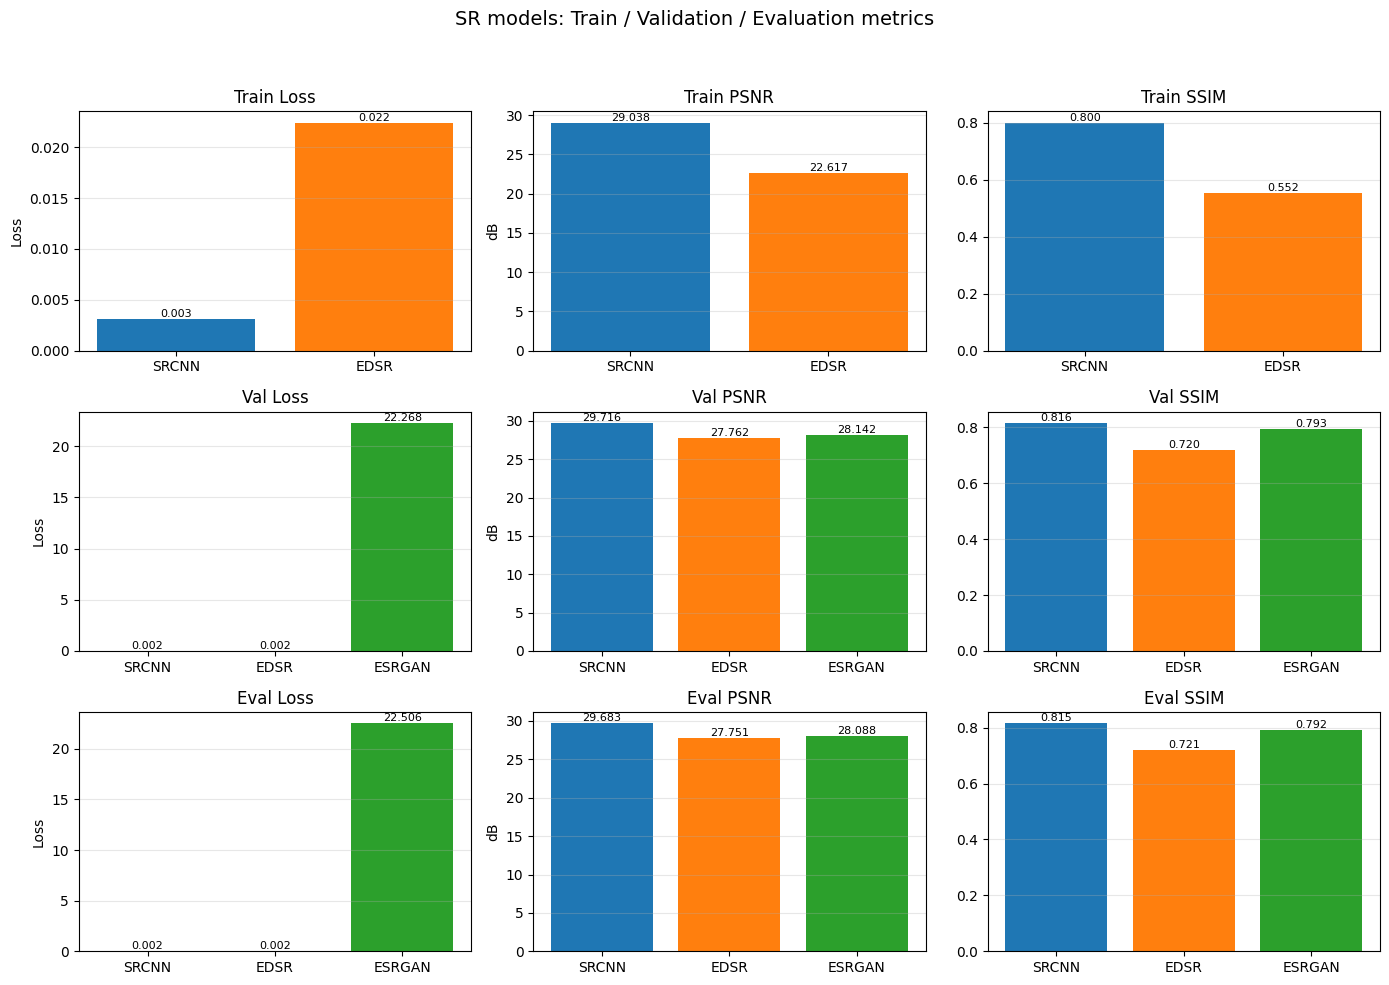

In [33]:
plot_sr_metrics(srcnn_train_metrics, edsr_train_metrics, esrgan_train_metrics, save_path="DL_results")

(<Figure size 1200x400 with 2 Axes>,
 array([<Axes: title={'center': 'Tiempo entrenamiento (s)'}, ylabel='Segundos'>,
        <Axes: title={'center': 'Tiempo evaluación (s)'}, ylabel='Segundos'>],
       dtype=object))

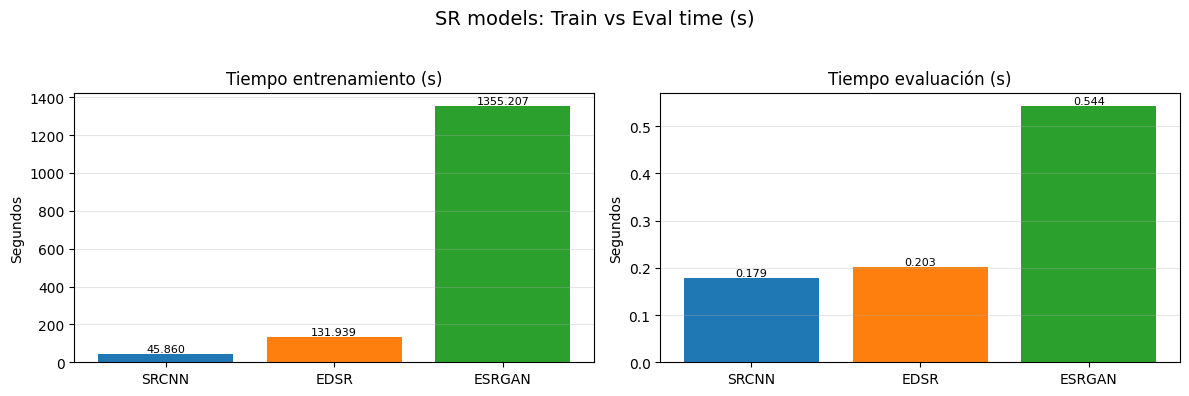

In [34]:
# Time panel
plot_sr_time(
    srcnn_train_metrics,
    edsr_train_metrics,
    esrgan_train_metrics,
    srcnn_time_mean,
    edsr_time_mean,
    esrgan_time_mean,
    save_path="DL_results",
)

(<Figure size 1400x800 with 4 Axes>,
 array([[<Axes: title={'center': 'Entrenamiento (media)'}, ylabel='MB'>,
         <Axes: title={'center': 'Entrenamiento (pico)'}, ylabel='MB'>],
        [<Axes: title={'center': 'Evaluación (media)'}, ylabel='MB'>,
         <Axes: title={'center': 'Evaluación (pico)'}, ylabel='MB'>]],
       dtype=object))

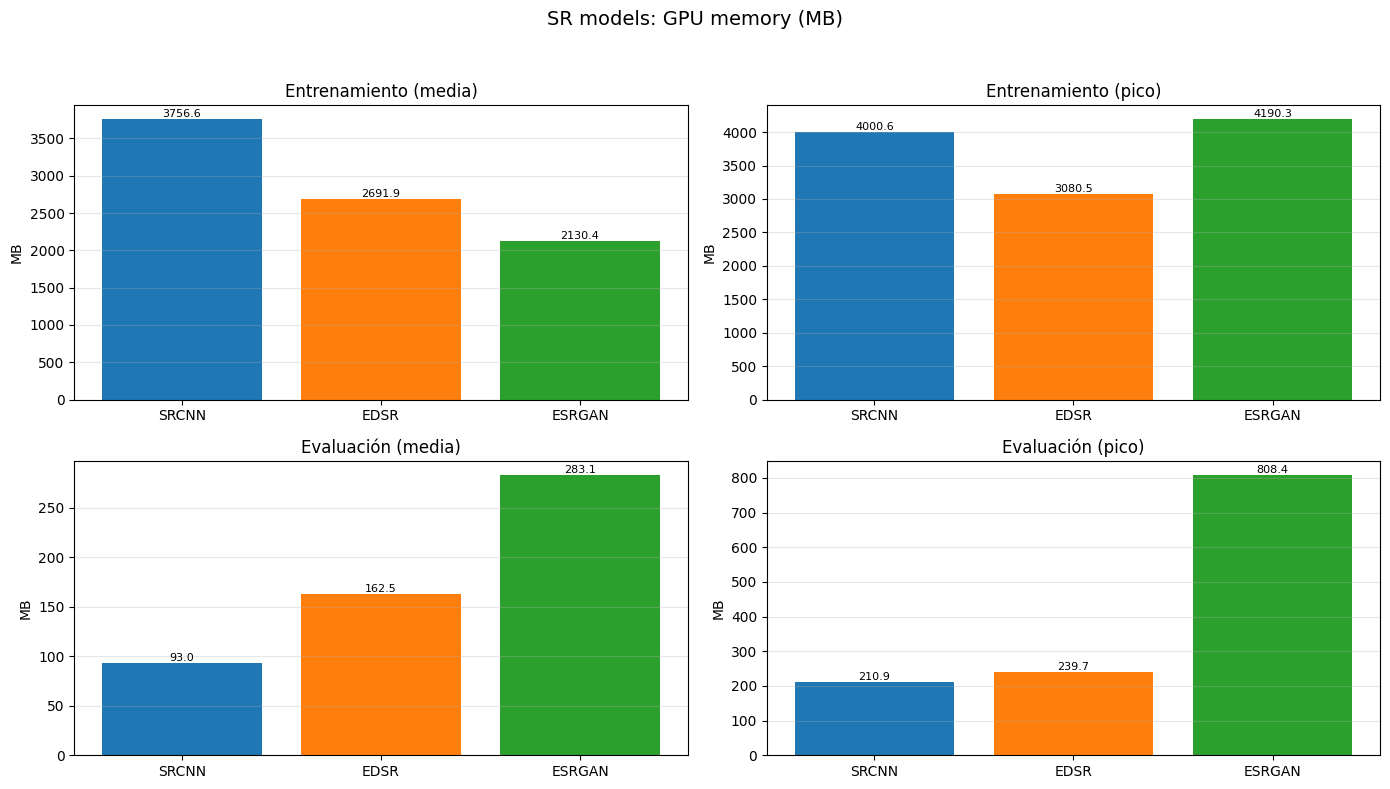

In [35]:
# Memory panel
plot_sr_memory(
    srcnn_train_metrics,
    edsr_train_metrics,
    esrgan_train_metrics,
    srcnn_gpu_mean_mean,
    edsr_gpu_mean_mean,
    esrgan_gpu_mean_mean,
    srcnn_gpu_peak_max,
    edsr_gpu_peak_max,
    esrgan_gpu_peak_max,
    save_path="DL_results",
)

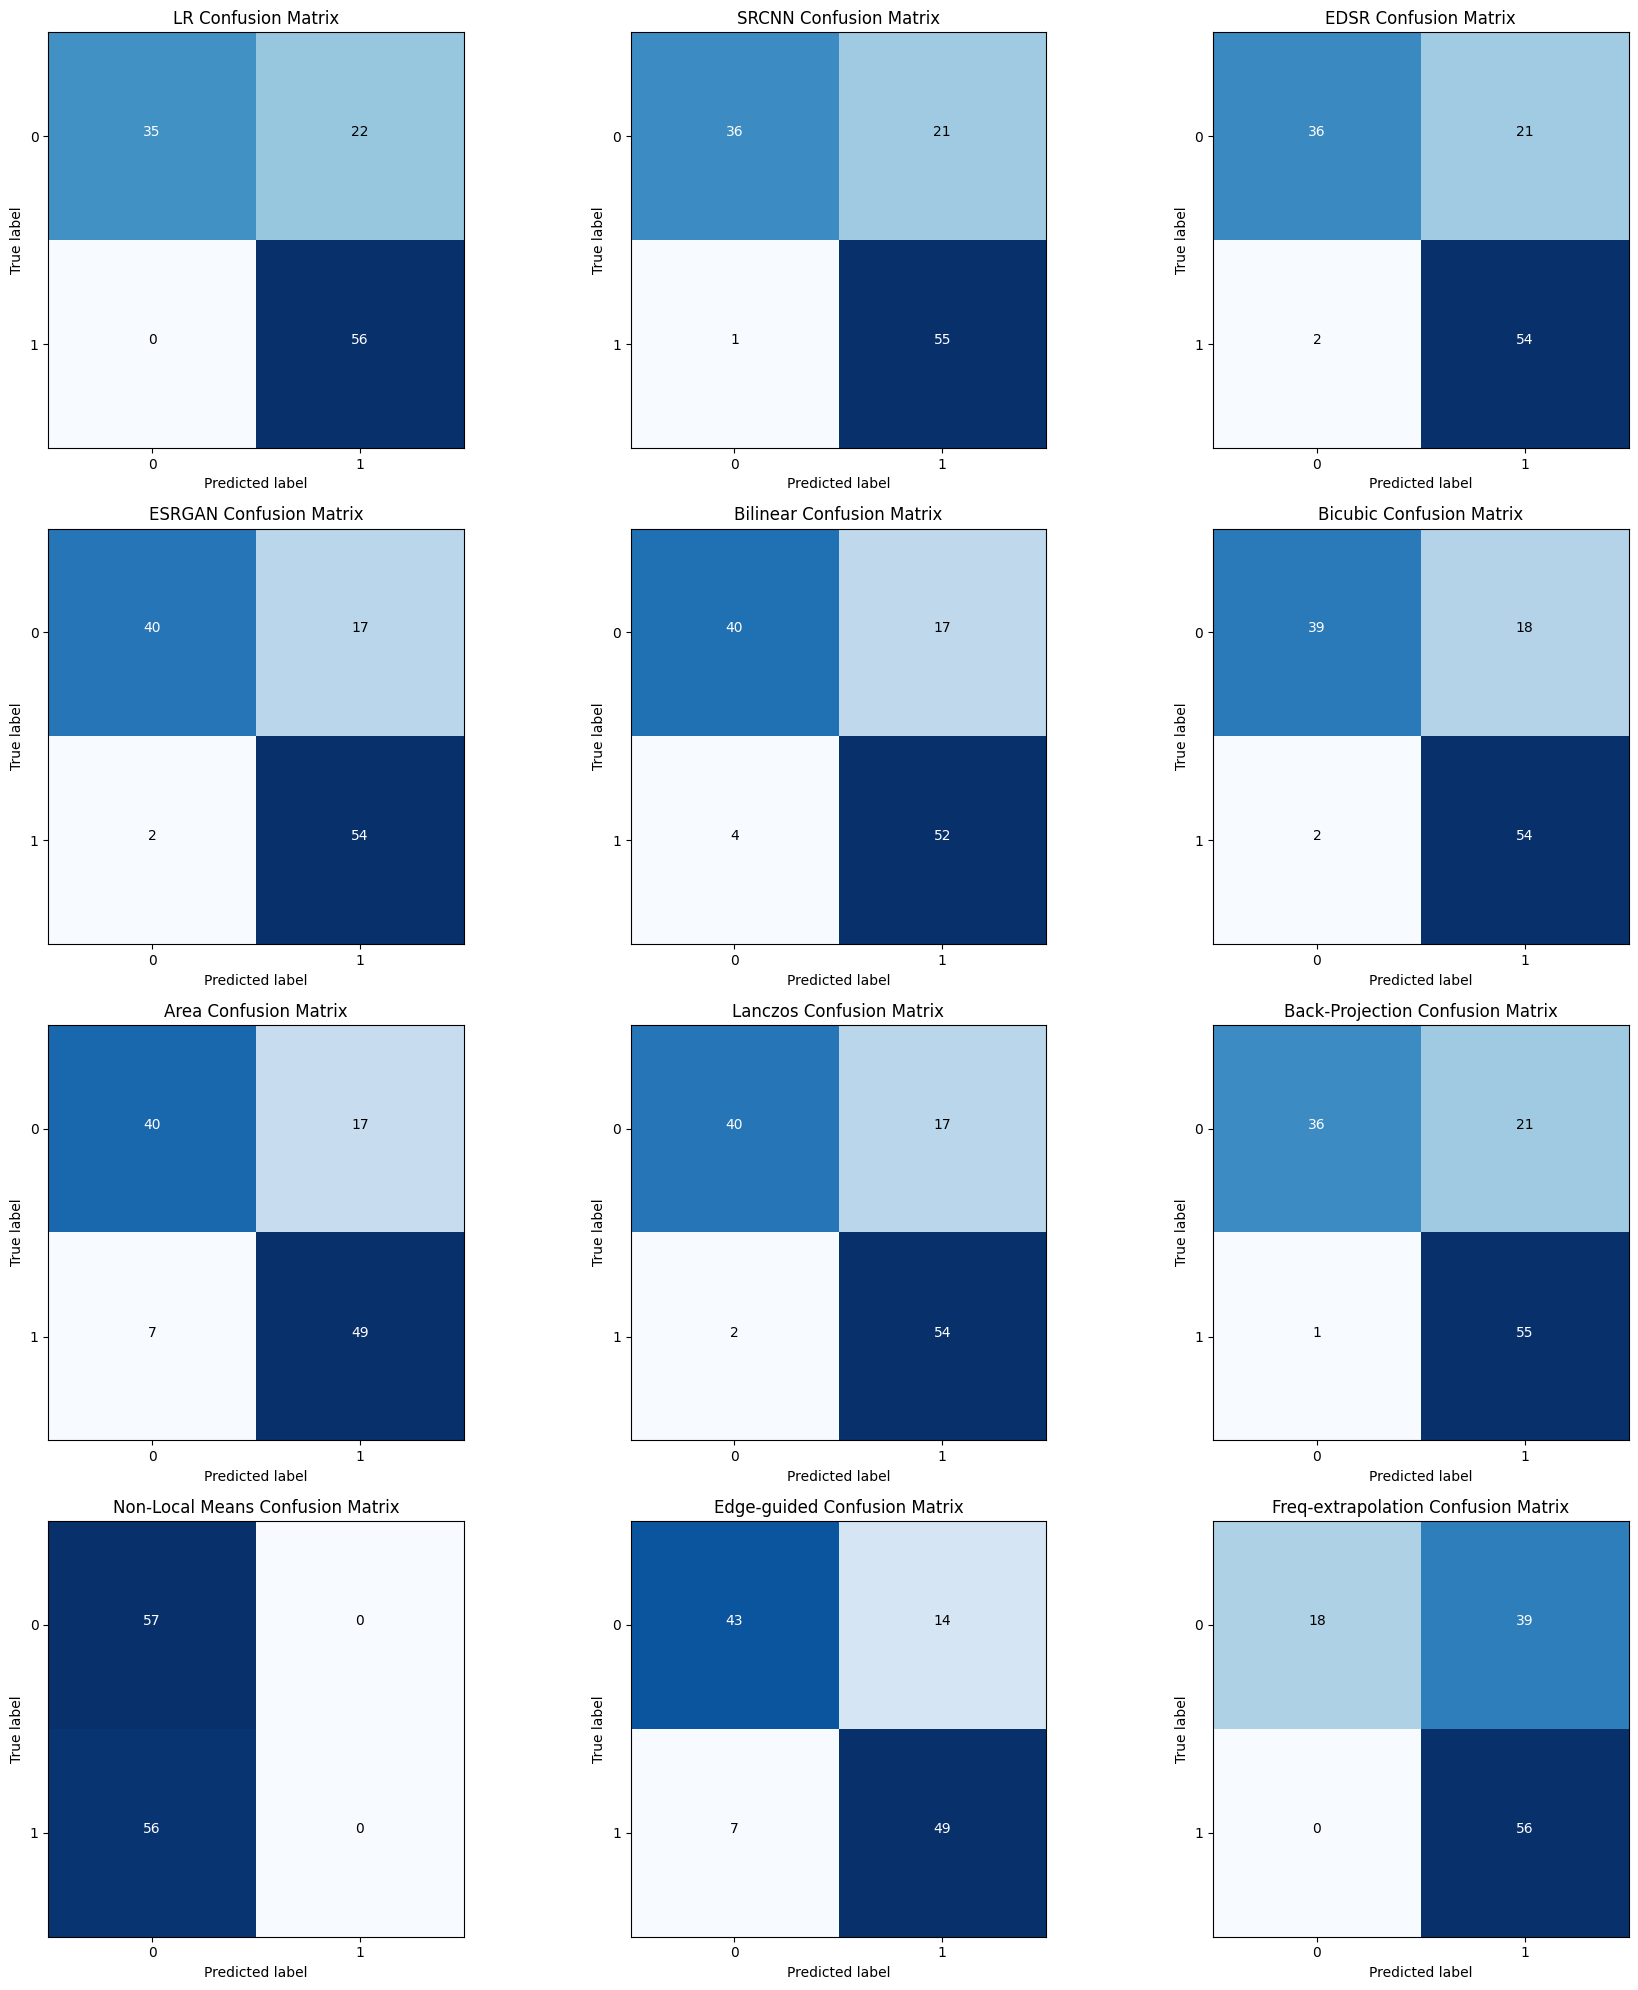

In [36]:
class_names = [str(c) for c in sorted(np.unique(y))]

label_sets = [
    ('LR', lr_labels),
    ('SRCNN', srcnn_labels),
    ('EDSR', edsr_labels),
    ('ESRGAN', esrgan_labels),
    ('Bilinear', bilinear_labels),
    ('Bicubic', bicubic_labels),
    ('Area', area_labels),
    ('Lanczos', lanczos_labels),
    ('Back-Projection', backproj_labels),
    ('Non-Local Means', nlm_labels),
    ('Edge-guided', edge_guided_labels),
    ('Freq-extrapolation', freq_extrap_labels),
]

cms = [(title, confusion_matrix(y, labels)) for title, labels in label_sets]

fig, axes = plt.subplots(4, 3, figsize=(18, 20))
axes = axes.flatten()

for i, (title, cm) in enumerate(cms):
    plot_confusion(axes[i], cm, class_names, title=f'{title} Confusion Matrix')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.047271665..1.0005099].


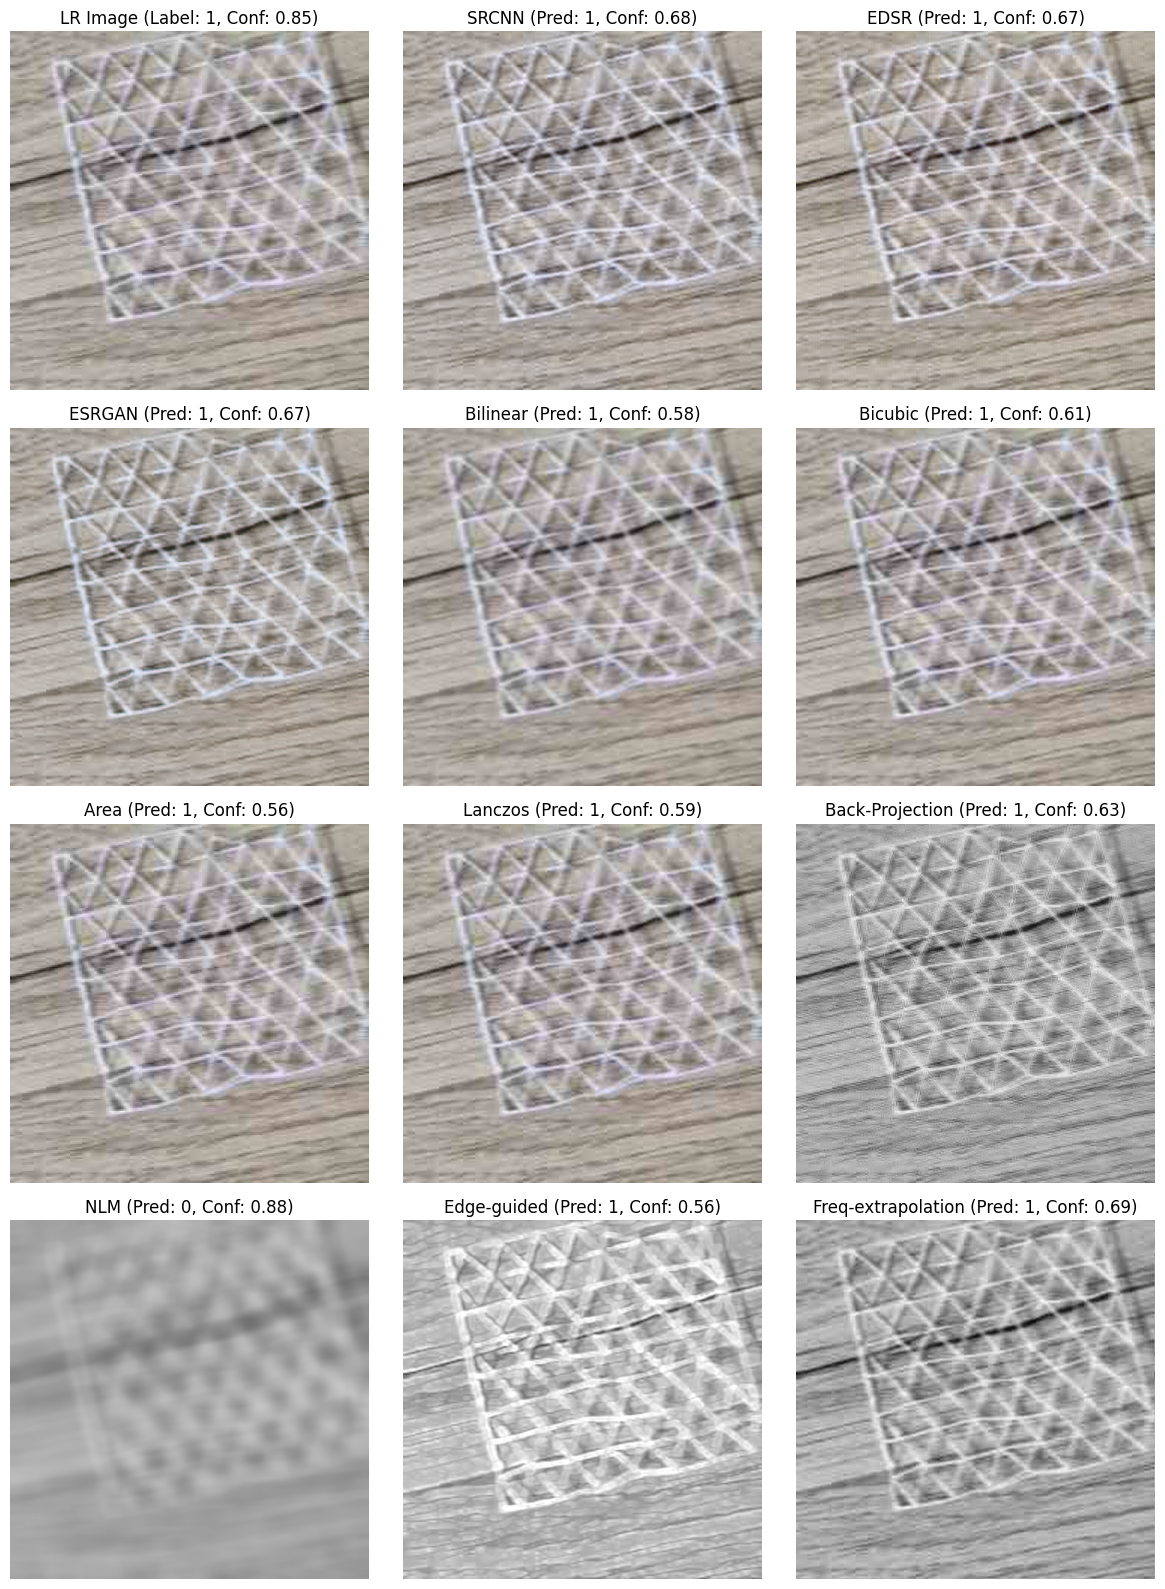

In [37]:
plot_4x3(
    images=[
        X_LR[0],
        srcnn_sr_images[0],
        edsr_sr_images[0],
        esrgan_sr_images[0],
        bilinear_sr_images[0],
        bicubic_sr_images[0],
        area_sr_images[0],
        lanczos_sr_images[0],
        backproj_sr_images[0],
        nlm_sr_images[0],
        edge_guided_sr_images[0],
        freq_extrap_sr_images[0]
    ],
    titles=[
        f"LR Image (Label: {y[0]}, Conf: {lr_confidences[0]:.2f})",
        f"SRCNN (Pred: {srcnn_labels[0]}, Conf: {srcnn_confidences[0]:.2f})",
        f"EDSR (Pred: {edsr_labels[0]}, Conf: {edsr_confidences[0]:.2f})",
        f"ESRGAN (Pred: {esrgan_labels[0]}, Conf: {esrgan_confidences[0]:.2f})",
        f"Bilinear (Pred: {bilinear_labels[0]}, Conf: {bilinear_confidences[0]:.2f})",
        f"Bicubic (Pred: {bicubic_labels[0]}, Conf: {bicubic_confidences[0]:.2f})",
        f"Area (Pred: {area_labels[0]}, Conf: {area_confidences[0]:.2f})",
        f"Lanczos (Pred: {lanczos_labels[0]}, Conf: {lanczos_confidences[0]:.2f})",
        f"Back-Projection (Pred: {backproj_labels[0]}, Conf: {backproj_confidences[0]:.2f})",
        f"NLM (Pred: {nlm_labels[0]}, Conf: {nlm_confidences[0]:.2f})",
        f"Edge-guided (Pred: {edge_guided_labels[0]}, Conf: {edge_guided_confidences[0]:.2f})",
        f"Freq-extrapolation (Pred: {freq_extrap_labels[0]}, Conf: {freq_extrap_confidences[0]:.2f})",
    ]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.074581854..1.0414435].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06894778..1.0556899].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06894778..1.0556899].


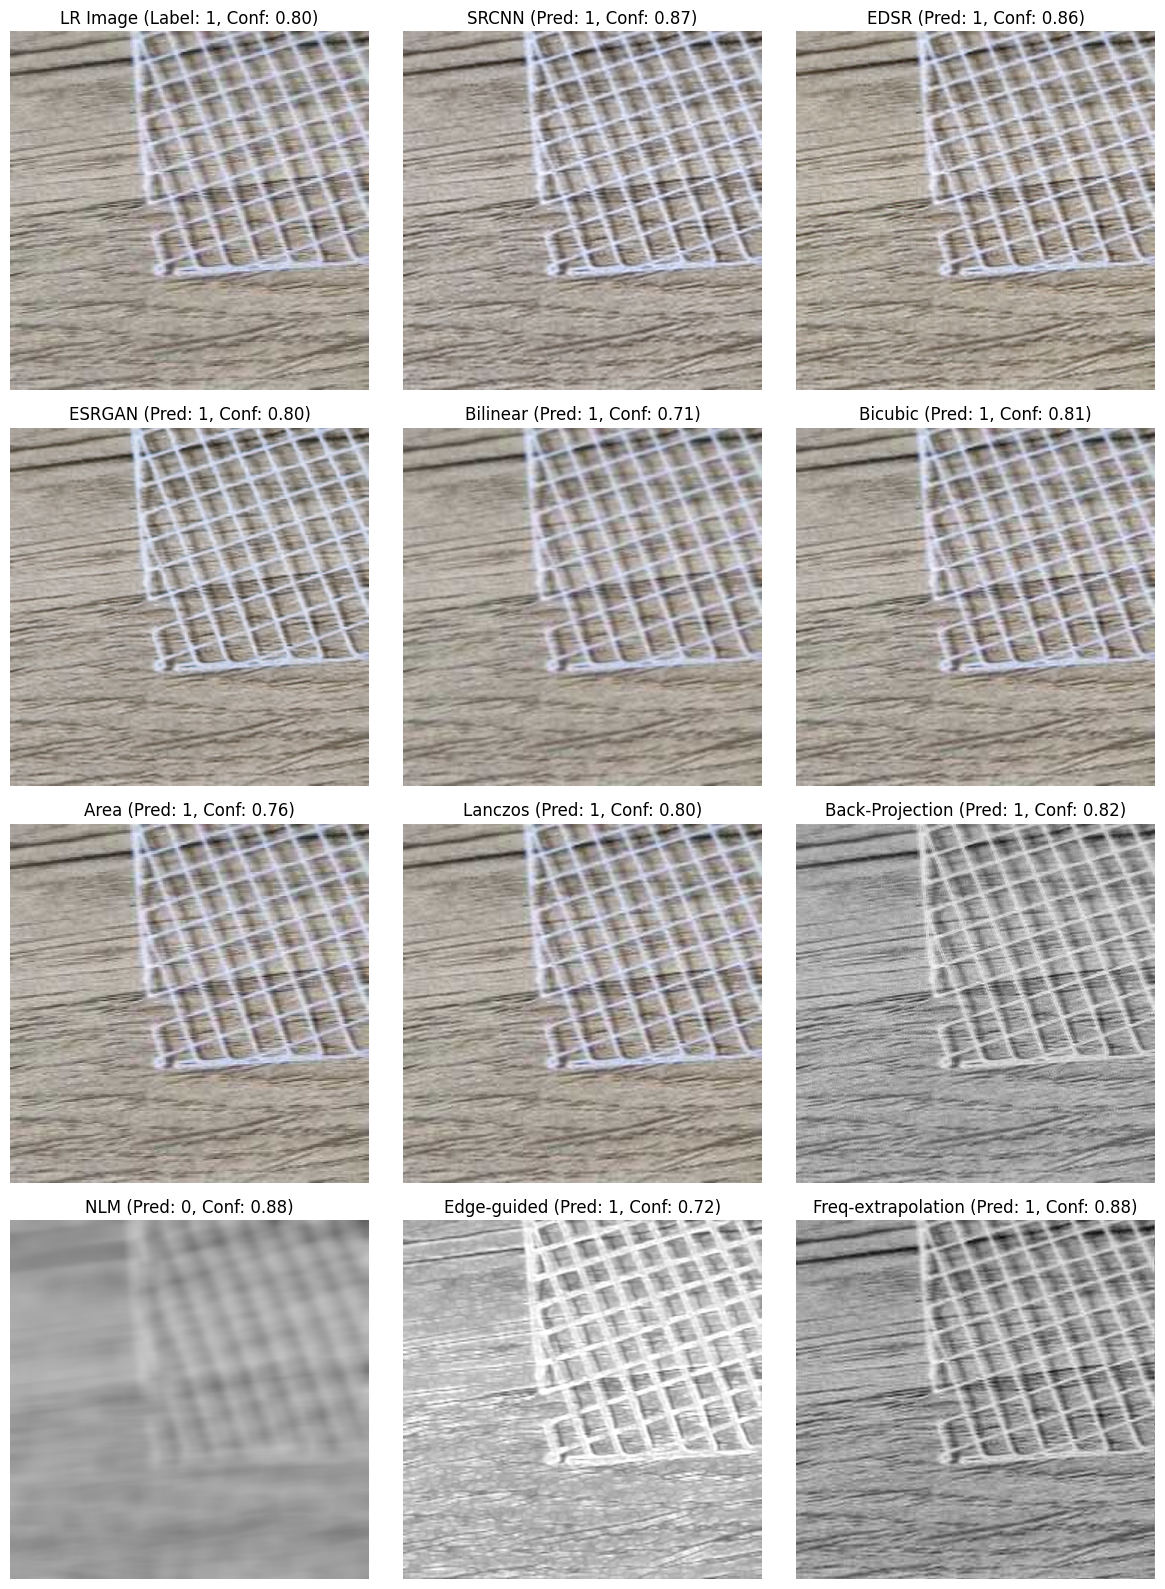

In [38]:
plot_4x3(
    images=[
        X_LR[20],
        srcnn_sr_images[20],
        edsr_sr_images[20],
        esrgan_sr_images[20],
        bilinear_sr_images[20],
        bicubic_sr_images[20],
        area_sr_images[20],
        lanczos_sr_images[20],
        backproj_sr_images[20],
        nlm_sr_images[20],
        edge_guided_sr_images[20],
        freq_extrap_sr_images[20]
    ],
    titles=[
        f"LR Image (Label: {y[20]}, Conf: {lr_confidences[20]:.2f})",
        f"SRCNN (Pred: {srcnn_labels[20]}, Conf: {srcnn_confidences[20]:.2f})",
        f"EDSR (Pred: {edsr_labels[20]}, Conf: {edsr_confidences[20]:.2f})",
        f"ESRGAN (Pred: {esrgan_labels[20]}, Conf: {esrgan_confidences[20]:.2f})",
        f"Bilinear (Pred: {bilinear_labels[20]}, Conf: {bilinear_confidences[20]:.2f})",
        f"Bicubic (Pred: {bicubic_labels[20]}, Conf: {bicubic_confidences[20]:.2f})",
        f"Area (Pred: {area_labels[20]}, Conf: {area_confidences[20]:.2f})",
        f"Lanczos (Pred: {lanczos_labels[20]}, Conf: {lanczos_confidences[20]:.2f})",
        f"Back-Projection (Pred: {backproj_labels[20]}, Conf: {backproj_confidences[20]:.2f})",
        f"NLM (Pred: {nlm_labels[20]}, Conf: {nlm_confidences[20]:.2f})",
        f"Edge-guided (Pred: {edge_guided_labels[20]}, Conf: {edge_guided_confidences[20]:.2f})",
        f"Freq-extrapolation (Pred: {freq_extrap_labels[20]}, Conf: {freq_extrap_confidences[20]:.2f})",
    ]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.28129095..1.0236157].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.28035375..1.0204452].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.28035375..1.0204452].


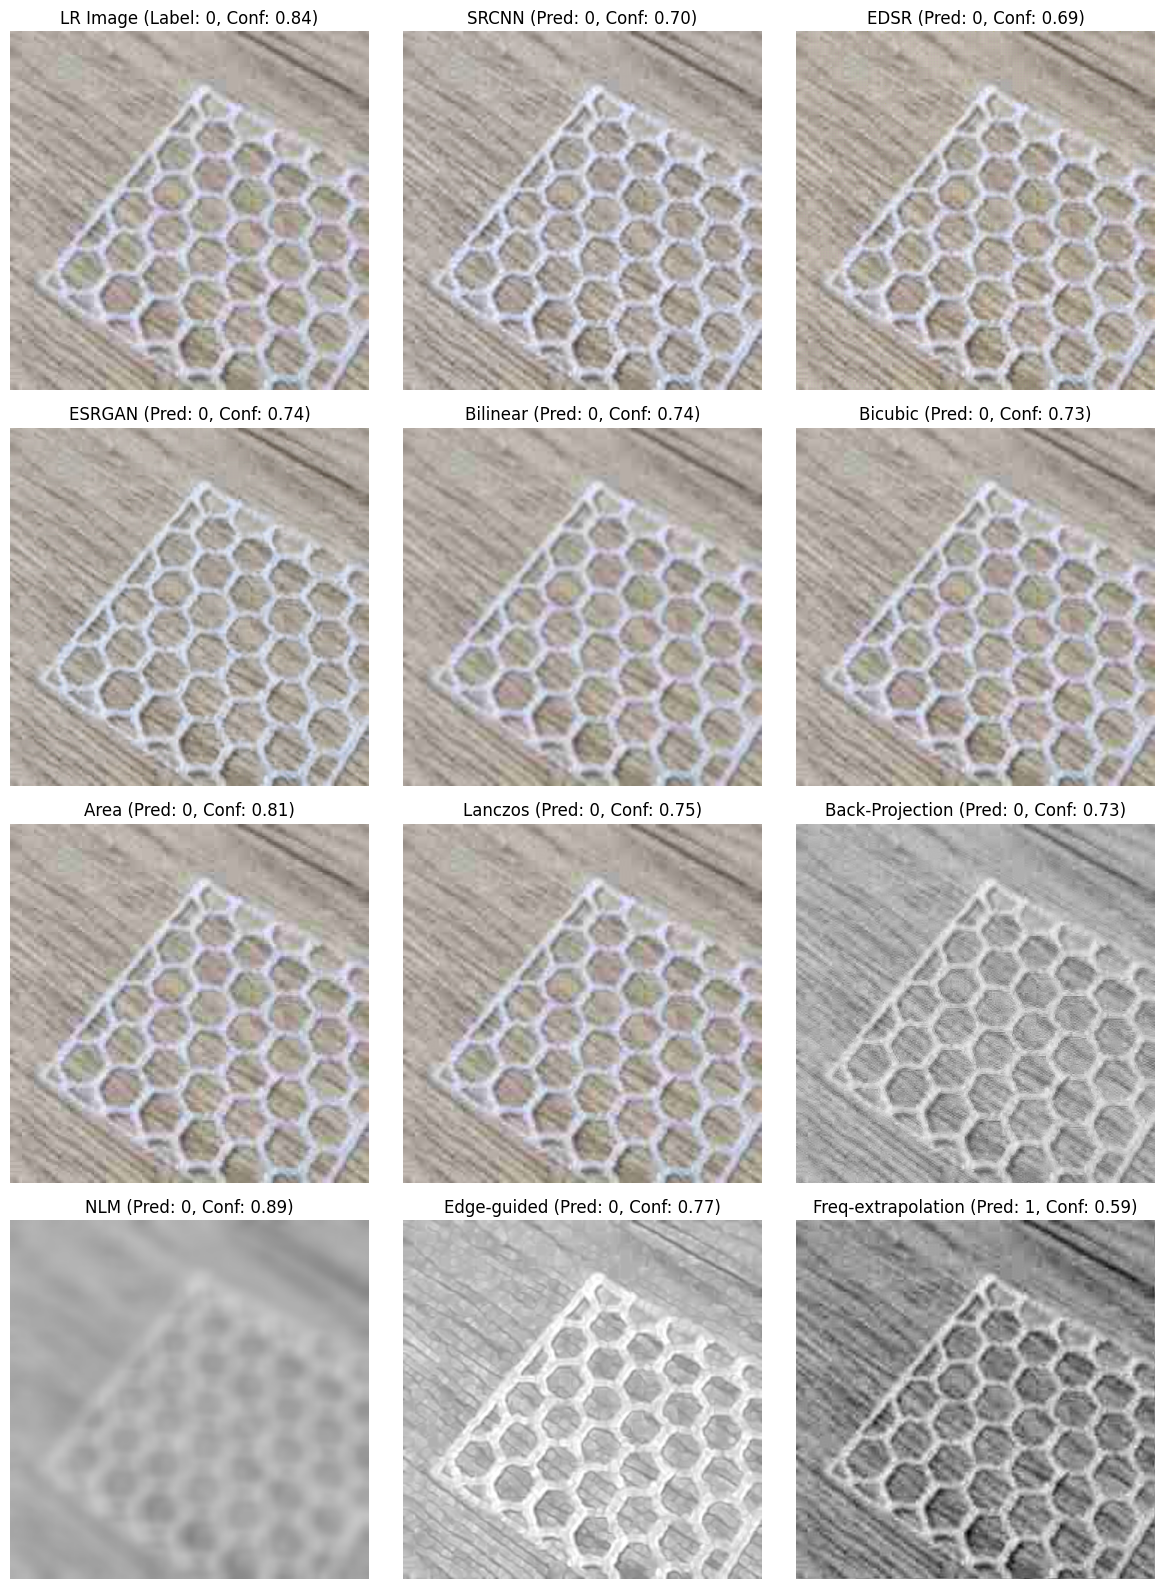

In [39]:
plot_4x3(
    images=[
        X_LR[80],
        srcnn_sr_images[80],
        edsr_sr_images[80],
        esrgan_sr_images[80],
        bilinear_sr_images[80],
        bicubic_sr_images[80],
        area_sr_images[80],
        lanczos_sr_images[80],
        backproj_sr_images[80],
        nlm_sr_images[80],
        edge_guided_sr_images[80],
        freq_extrap_sr_images[80]
    ],
    titles=[
        f"LR Image (Label: {y[80]}, Conf: {lr_confidences[80]:.2f})",
        f"SRCNN (Pred: {srcnn_labels[80]}, Conf: {srcnn_confidences[80]:.2f})",
        f"EDSR (Pred: {edsr_labels[80]}, Conf: {edsr_confidences[80]:.2f})",
        f"ESRGAN (Pred: {esrgan_labels[80]}, Conf: {esrgan_confidences[80]:.2f})",
        f"Bilinear (Pred: {bilinear_labels[80]}, Conf: {bilinear_confidences[80]:.2f})",
        f"Bicubic (Pred: {bicubic_labels[80]}, Conf: {bicubic_confidences[80]:.2f})",
        f"Area (Pred: {area_labels[80]}, Conf: {area_confidences[80]:.2f})",
        f"Lanczos (Pred: {lanczos_labels[80]}, Conf: {lanczos_confidences[80]:.2f})",
        f"Back-Projection (Pred: {backproj_labels[80]}, Conf: {backproj_confidences[80]:.2f})",
        f"NLM (Pred: {nlm_labels[80]}, Conf: {nlm_confidences[80]:.2f})",
        f"Edge-guided (Pred: {edge_guided_labels[80]}, Conf: {edge_guided_confidences[80]:.2f})",
        f"Freq-extrapolation (Pred: {freq_extrap_labels[80]}, Conf: {freq_extrap_confidences[80]:.2f})",
    ]
)

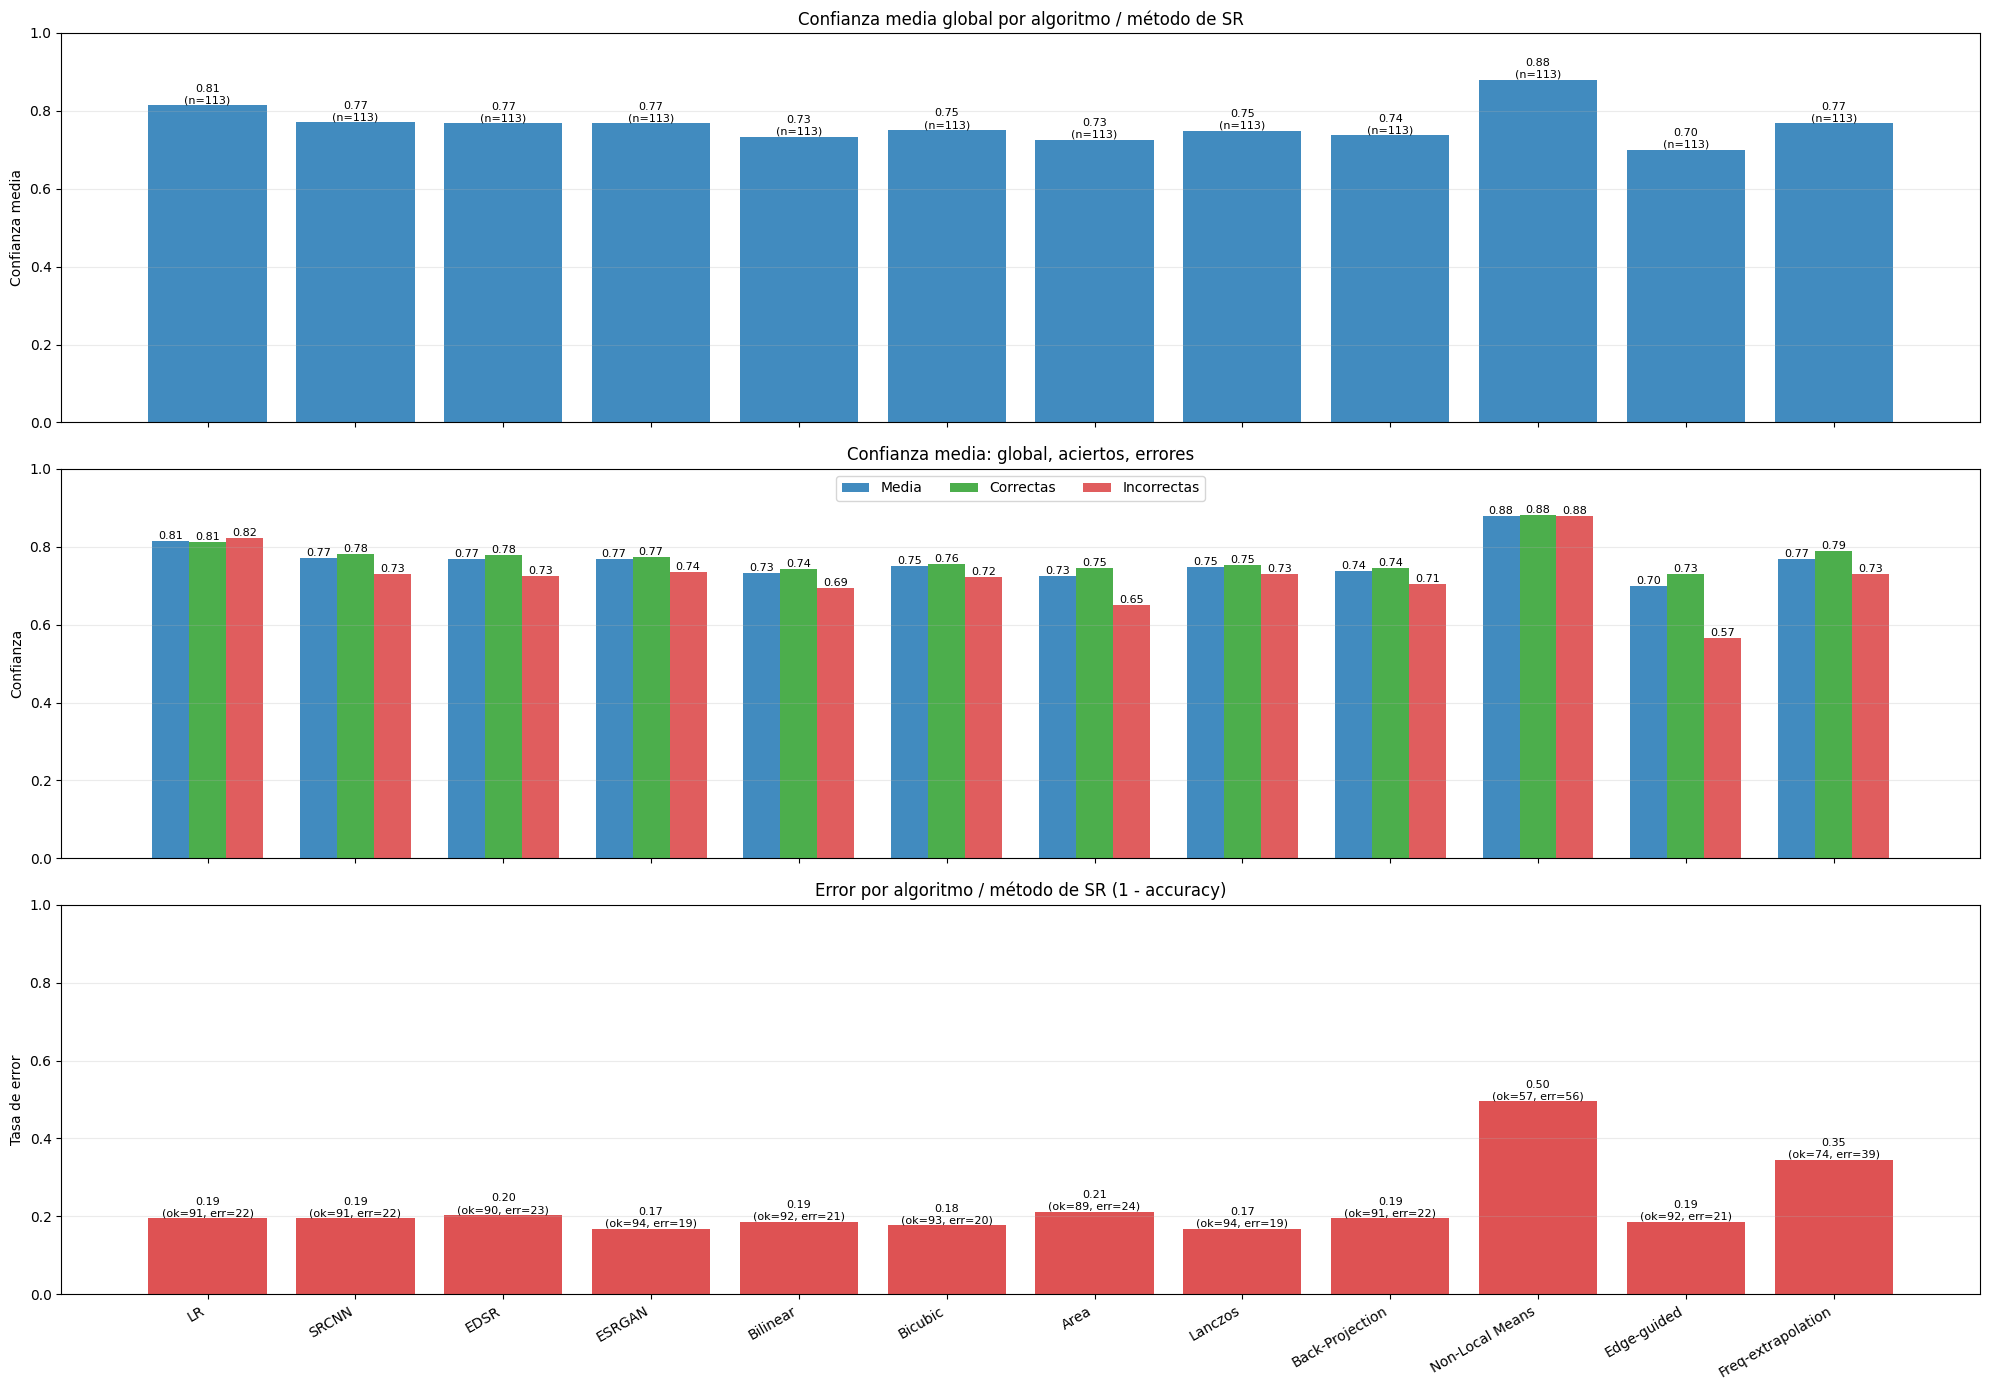

In [42]:
# Panel: Confianzas y error por algoritmo/método de SR en una sola figura (3 filas x 1 columna)
# - Subplot 1: Confianza media global
# - Subplot 2: Confianza media en global/correctas/incorrectas (barras agrupadas)
# - Subplot 3: Tasa de error (1 - accuracy)

algo_names = [
    'LR', 'SRCNN', 'EDSR', 'ESRGAN',
    'Bilinear', 'Bicubic', 'Area', 'Lanczos',
    'Back-Projection', 'Non-Local Means', 'Edge-guided', 'Freq-extrapolation'
]

label_lists = [
    lr_labels,
    srcnn_labels,
    edsr_labels,
    esrgan_labels,
    bilinear_labels,
    bicubic_labels,
    area_labels,
    lanczos_labels,
    backproj_labels,
    nlm_labels,
    edge_guided_labels,
    freq_extrap_labels,
]

conf_lists = [
    lr_confidences,
    srcnn_confidences,
    edsr_confidences,
    esrgan_confidences,
    bilinear_confidences,
    bicubic_confidences,
    area_confidences,
    lanczos_confidences,
    backproj_confidences,
    nlm_confidences,
    edge_guided_confidences,
    freq_extrap_confidences,
]

mean_conf_all = []
mean_conf_correct = []
mean_conf_wrong = []
error_rates = []
counts = []
counts_correct = []
counts_wrong = []

yt = np.asarray(y, dtype=int)

for preds, confs in zip(label_lists, conf_lists):
    yp = np.asarray(preds, dtype=int)
    cf = np.asarray(confs, dtype=float)
    n = int(min(len(yt), len(yp), len(cf)))
    if n == 0:
        mean_conf_all.append(np.nan)
        mean_conf_correct.append(np.nan)
        mean_conf_wrong.append(np.nan)
        error_rates.append(np.nan)
        counts.append(0)
        counts_correct.append(0)
        counts_wrong.append(0)
        continue
    y_true = yt[:n]
    y_pred = yp[:n]
    cfs = cf[:n]

    correct = (y_pred == y_true)
    err_rate = 1.0 - float(np.mean(correct))

    mean_all = float(np.nanmean(cfs)) if n > 0 else np.nan
    mean_corr = float(np.nanmean(cfs[correct])) if np.any(correct) else np.nan
    mean_wrong = float(np.nanmean(cfs[~correct])) if np.any(~correct) else np.nan

    mean_conf_all.append(mean_all)
    mean_conf_correct.append(mean_corr)
    mean_conf_wrong.append(mean_wrong)
    error_rates.append(err_rate)
    counts.append(n)
    counts_correct.append(int(np.sum(correct)))
    counts_wrong.append(int(n - np.sum(correct)))

# Figura única con 3 subplots apilados
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 1, figsize=(20, 14), sharex=True)
idx = np.arange(len(algo_names))

# Subplot 1: confianza media global
bars1 = axes[0].bar(idx, mean_conf_all, color='tab:blue', alpha=0.85)
axes[0].set_ylabel('Confianza media')
axes[0].set_title('Confianza media global por algoritmo / método de SR')
axes[0].set_ylim(0.0, 1.0)
axes[0].grid(axis='y', alpha=0.25)
for b, m, n in zip(bars1, mean_conf_all, counts):
    if np.isfinite(m):
        axes[0].text(b.get_x() + b.get_width()/2, m, f'{m:.2f}\n(n={n})', ha='center', va='bottom', fontsize=8)

# Subplot 2: barras agrupadas (global/correctas/incorrectas)
w = 0.25
axes[1].bar(idx - w, mean_conf_all, width=w, label='Media', color='tab:blue', alpha=0.85)
axes[1].bar(idx,      mean_conf_correct, width=w, label='Correctas', color='tab:green', alpha=0.85)
axes[1].bar(idx + w,  mean_conf_wrong, width=w, label='Incorrectas', color='tab:red', alpha=0.75)
axes[1].set_ylabel('Confianza')
axes[1].set_title('Confianza media: global, aciertos, errores')
axes[1].set_ylim(0.0, 1.0)
axes[1].grid(axis='y', alpha=0.25)
axes[1].legend(ncols=3, loc='upper center')
for i in range(len(algo_names)):
    vals = [mean_conf_all[i], mean_conf_correct[i], mean_conf_wrong[i]]
    xs = [idx[i] - w, idx[i], idx[i] + w]
    for xv, v in zip(xs, vals):
        if np.isfinite(v):
            axes[1].text(xv, v, f'{v:.2f}', ha='center', va='bottom', fontsize=8)

# Subplot 3: tasa de error (1 - accuracy)
bars3 = axes[2].bar(idx, error_rates, color='tab:red', alpha=0.8)
axes[2].set_xticks(idx)
axes[2].set_xticklabels(algo_names, rotation=30, ha='right')
axes[2].set_ylabel('Tasa de error')
axes[2].set_title('Error por algoritmo / método de SR (1 - accuracy)')
axes[2].set_ylim(0.0, 1.0)
axes[2].grid(axis='y', alpha=0.25)
for b, e, nc, nw in zip(bars3, error_rates, counts_correct, counts_wrong):
    if np.isfinite(e):
        axes[2].text(b.get_x() + b.get_width()/2, e, f'{e:.2f}\n(ok={nc}, err={nw})', ha='center', va='bottom', fontsize=8)

plt.tight_layout()

# Guardar figura combinada
try:
    os.makedirs('DL_results', exist_ok=True)
    fig.savefig(os.path.join('DL_results', 'sr_confidence_error_panel.png'), dpi=150)
except Exception as e:
    print('Aviso: no se pudo guardar sr_confidence_error_panel.png:', e)
    
plt.show()